In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from ucimlrepo import fetch_ucirepo
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import resample

In [4]:
# Fetch dataset
predict_students_dropout_and_academic_success = fetch_ucirepo(id=697)
X = predict_students_dropout_and_academic_success.data.features
y = predict_students_dropout_and_academic_success.data.targets

In [5]:
# Combine features and target into a single DataFrame
df = pd.concat([X, y], axis=1)

# Encode target variable
mapping = {'Graduate': 0, 'Dropout': 1, 'Enrolled': 2}
df['Target_encoded'] = df['Target'].map(mapping)

In [6]:
# Drop the original target column
df = df.drop('Target', axis=1)

# Split the data into features and target
X = df.drop(columns=['Target_encoded'])
y = df['Target_encoded']

# Split the data into training and testing sets
X_train_full, X_test_full, y_train_full, y_test_full = train_test_split(X, y, test_size=0.2, random_state=17)

In [7]:
# Define common parameters for models
common_params = {
    'max_depth': 9,
    'learning_rate': 0.01,
    'n_estimators': 200
}

In [8]:
# Define models
models = {
    'CatBoost': CatBoostClassifier(verbose=0, random_state=17, **common_params),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=17, **common_params),
    'RandomForest': RandomForestClassifier(random_state=17, max_depth=common_params['max_depth'], n_estimators=common_params['n_estimators'])
}

In [9]:
# Function to evaluate models
def evaluate_model(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    roc_auc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr')

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'roc_auc': roc_auc,
        'y_pred_proba': y_pred_proba
    }

In [10]:
# Evaluate models on full dataset
results_full = {}
for model_name, model in models.items():
    print(f"Training {model_name} on full dataset...")
    results_full[model_name] = evaluate_model(model, X_train_full, y_train_full, X_test_full, y_test_full)

Training CatBoost on full dataset...
Training XGBoost on full dataset...


D:\LLM_exp\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:27:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Training RandomForest on full dataset...


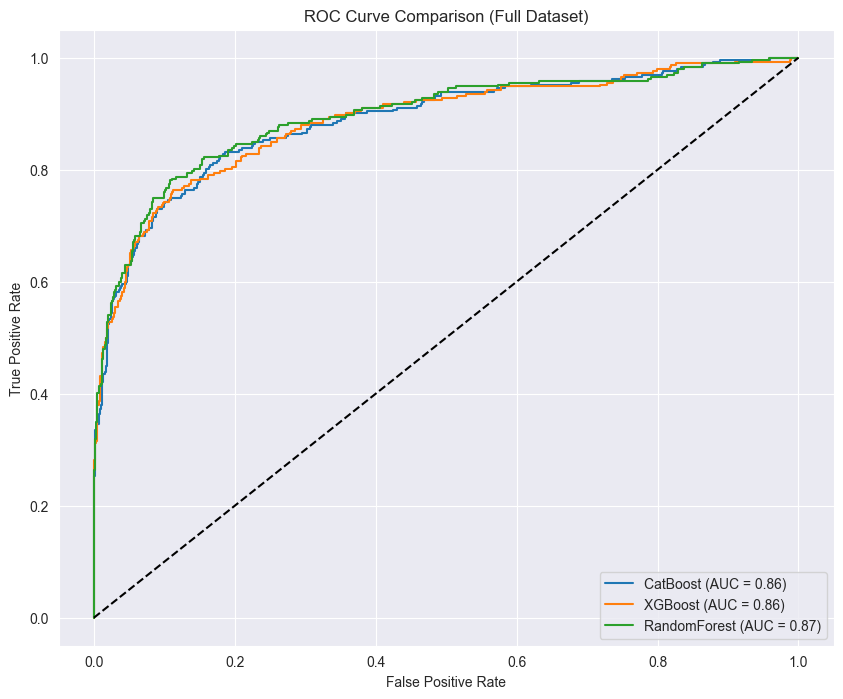

In [11]:
# Plot ROC curves for full dataset
plt.figure(figsize=(10, 8))
for model_name, result in results_full.items():
    fpr, tpr, _ = roc_curve(y_test_full, result['y_pred_proba'][:, 1], pos_label=1)
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {result["roc_auc"]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison (Full Dataset)')
plt.legend(loc='lower right')
plt.show()

In [12]:
# Print results for full dataset
for model_name, result in results_full.items():
    print(f"\nModel: {model_name}")
    print(f"Accuracy: {result['accuracy']:.4f}")
    print(f"Precision: {result['precision']:.4f}")
    print(f"Recall: {result['recall']:.4f}")
    print(f"F1-Score: {result['f1']:.4f}")
    print(f"ROC-AUC: {result['roc_auc']:.4f}")


Model: CatBoost
Accuracy: 0.7503
Precision: 0.7259
Recall: 0.7503
F1-Score: 0.7280
ROC-AUC: 0.8557

Model: XGBoost
Accuracy: 0.7492
Precision: 0.7426
Recall: 0.7492
F1-Score: 0.7416
ROC-AUC: 0.8610

Model: RandomForest
Accuracy: 0.7582
Precision: 0.7399
Recall: 0.7582
F1-Score: 0.7395
ROC-AUC: 0.8690


In [13]:
# Slice the dataset
df_sliced = df.sample(frac=0.1, random_state=17)
X_sliced = df_sliced.drop('Target_encoded', axis=1)
y_sliced = df_sliced['Target_encoded']

In [14]:
# Split the sliced data into training and testing sets
X_train_sliced, X_test_sliced, y_train_sliced, y_test_sliced = train_test_split(X_sliced, y_sliced, test_size=0.2, random_state=17)

In [15]:
# Evaluate models on sliced dataset
results_sliced = {}
for model_name, model in models.items():
    print(f"Training {model_name} on sliced dataset...")
    results_sliced[model_name] = evaluate_model(model, X_train_sliced, y_train_sliced, X_test_full, y_test_full)

Training CatBoost on sliced dataset...
Training XGBoost on sliced dataset...


D:\LLM_exp\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:27:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Training RandomForest on sliced dataset...


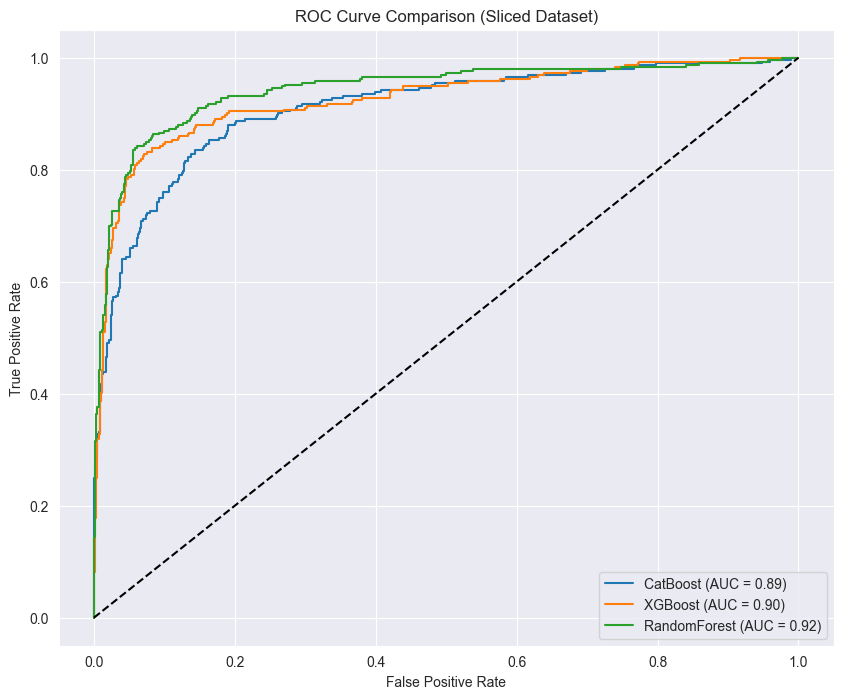

In [16]:
# Plot ROC curves for sliced dataset
plt.figure(figsize=(10, 8))
for model_name, result in results_sliced.items():
    fpr, tpr, _ = roc_curve(y_test_full, result['y_pred_proba'][:, 1], pos_label=1)
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {result["roc_auc"]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison (Sliced Dataset)')
plt.legend(loc='lower right')
plt.show()

In [17]:
# Print results for sliced dataset
for model_name, result in results_sliced.items():
    print(f"\nModel: {model_name}")
    print(f"Accuracy: {result['accuracy']:.4f}")
    print(f"Precision: {result['precision']:.4f}")
    print(f"Recall: {result['recall']:.4f}")
    print(f"F1-Score: {result['f1']:.4f}")
    print(f"ROC-AUC: {result['roc_auc']:.4f}")


Model: CatBoost
Accuracy: 0.7718
Precision: 0.8036
Recall: 0.7718
F1-Score: 0.7333
ROC-AUC: 0.8910

Model: XGBoost
Accuracy: 0.8147
Precision: 0.8092
Recall: 0.8147
F1-Score: 0.8110
ROC-AUC: 0.9007

Model: RandomForest
Accuracy: 0.8407
Precision: 0.8423
Recall: 0.8407
F1-Score: 0.8307
ROC-AUC: 0.9201


In [18]:
# Save the sliced dataset to a CSV file
df_sliced.to_csv('D:/LLM_exp/df_sliced.csv', index=False)

# Load the synthetic dataset generated by GPT
df_gpt = pd.read_csv('D:/LLM_exp/synthetic_dataset.csv')

In [19]:
# Evaluate models on GPT-generated dataset
results_gpt = {}
for model_name, model in models.items():
    print(f"Training {model_name} on GPT-generated dataset...")
    results_gpt[model_name] = evaluate_model(model, X_train_full, y_train_full, X_test_full, y_test_full)

Training CatBoost on GPT-generated dataset...
Training XGBoost on GPT-generated dataset...


D:\LLM_exp\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:27:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Training RandomForest on GPT-generated dataset...


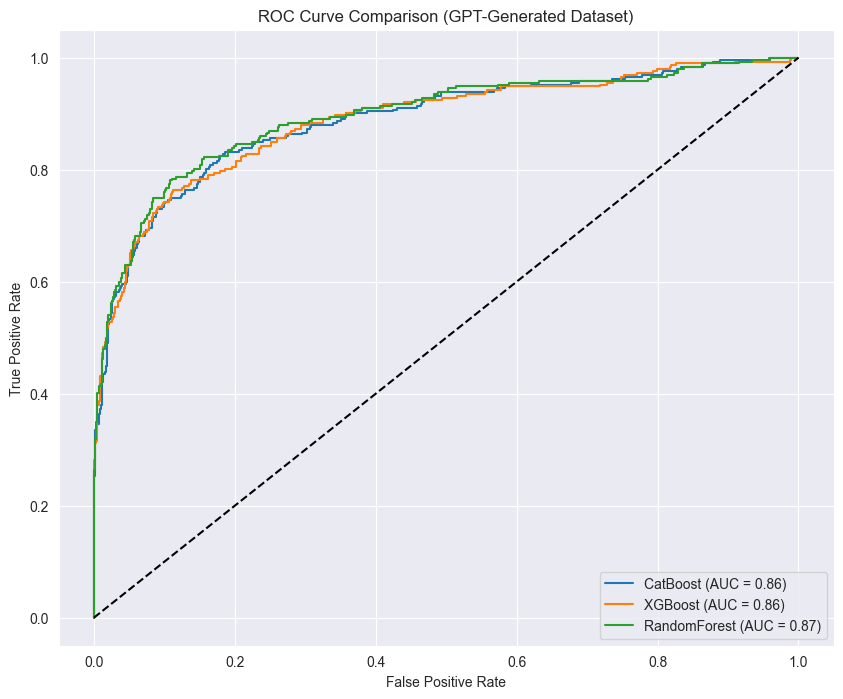

In [20]:
# Plot ROC curves for GPT-generated dataset
plt.figure(figsize=(10, 8))
for model_name, result in results_gpt.items():
    fpr, tpr, _ = roc_curve(y_test_full, result['y_pred_proba'][:, 1], pos_label=1)
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {result["roc_auc"]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison (GPT-Generated Dataset)')
plt.legend(loc='lower right')
plt.show()

In [21]:
# Print results for GPT-generated dataset
for model_name, result in results_gpt.items():
    print(f"\nModel: {model_name}")
    print(f"Accuracy: {result['accuracy']:.4f}")
    print(f"Precision: {result['precision']:.4f}")
    print(f"Recall: {result['recall']:.4f}")
    print(f"F1-Score: {result['f1']:.4f}")
    print(f"ROC-AUC: {result['roc_auc']:.4f}")


Model: CatBoost
Accuracy: 0.7503
Precision: 0.7259
Recall: 0.7503
F1-Score: 0.7280
ROC-AUC: 0.8557

Model: XGBoost
Accuracy: 0.7492
Precision: 0.7426
Recall: 0.7492
F1-Score: 0.7416
ROC-AUC: 0.8610

Model: RandomForest
Accuracy: 0.7582
Precision: 0.7399
Recall: 0.7582
F1-Score: 0.7395
ROC-AUC: 0.8690


In [22]:
# Function to evaluate models with additional metrics
def evaluate_model(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    roc_auc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr')

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'roc_auc': roc_auc,
        'y_pred_proba': y_pred_proba
    }

In [23]:
# Function to generate a new dataset using resampling (Deepseek)
def generate_new_dataset(original_df, multiplier=10):
    new_data = []
    for _ in range(multiplier):
        resampled_df = resample(original_df, replace=True, n_samples=len(original_df), random_state=np.random.randint(0, 100))
        new_data.append(resampled_df)
    return pd.concat(new_data, ignore_index=True)

In [24]:
# Function to generate synthetic data (Copilot)
def generate_synthetic_data(data, size_multiplier=10):
    synthetic_data = pd.DataFrame()
    for col in data.columns:
        if col == "Target_encoded":
            synthetic_data[col] = np.random.choice([0, 1, 2], len(data) * size_multiplier)
        elif data[col].dtype in [np.float64, np.int64]:
            synthetic_data[col] = np.random.normal(data[col].mean(), data[col].std(), len(data) * size_multiplier)
        else:
            synthetic_data[col] = np.random.choice(data[col], len(data) * size_multiplier)
    return synthetic_data


In [25]:
# Load the sliced dataset
df_sliced = pd.read_csv('df_sliced.csv')

# Generate deepseek dataset using resampling
df_deepseek = generate_new_dataset(df_sliced, multiplier=10)

# Generate copilot dataset using synthetic data generation
df_copilot = generate_synthetic_data(df_sliced)

In [26]:

# Prepare datasets for training and testing
def prepare_datasets(df):
    X = df.drop('Target_encoded', axis=1)
    y = df['Target_encoded']
    return train_test_split(X, y, test_size=0.2, random_state=17)


In [27]:
X_train_deepseek, X_test_deepseek, y_train_deepseek, y_test_deepseek = prepare_datasets(df_deepseek)
X_train_copilot, X_test_copilot, y_train_copilot, y_test_copilot = prepare_datasets(df_copilot)

In [28]:
# Evaluate models on deepseek dataset
results_deepseek = {}
for model_name, model in models.items():
    print(f"Training {model_name} on deepseek dataset...")
    results_deepseek[model_name] = evaluate_model(model, X_train_deepseek, y_train_deepseek, X_test_full, y_test_full)

Training CatBoost on deepseek dataset...
Training XGBoost on deepseek dataset...


D:\LLM_exp\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:28:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Training RandomForest on deepseek dataset...


In [29]:
# Evaluate models on copilot dataset
results_copilot = {}
for model_name, model in models.items():
    print(f"Training {model_name} on copilot dataset...")
    results_copilot[model_name] = evaluate_model(model, X_train_copilot, y_train_copilot, X_test_full, y_test_full)

Training CatBoost on copilot dataset...
Training XGBoost on copilot dataset...


D:\LLM_exp\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:28:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Training RandomForest on copilot dataset...


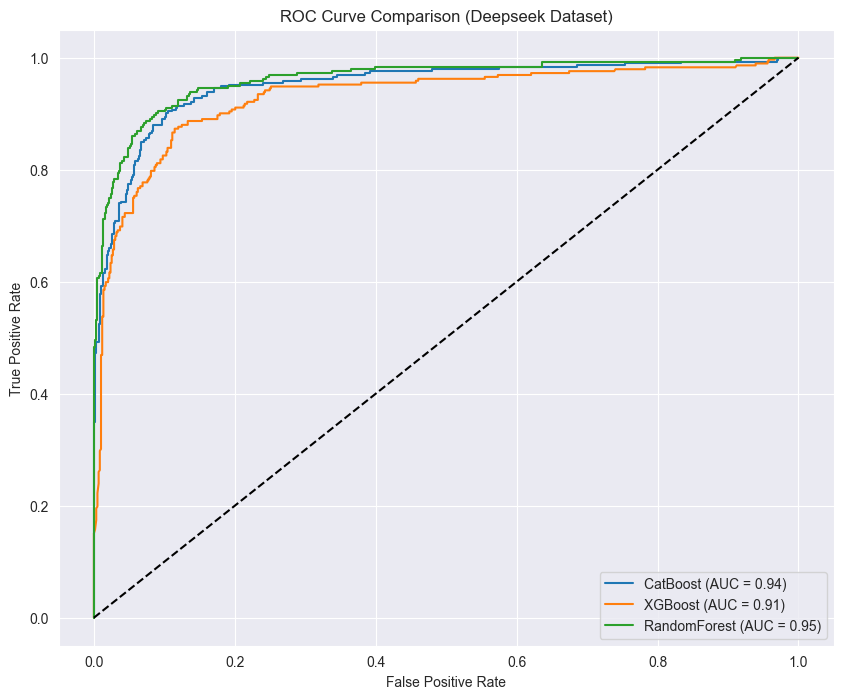

In [30]:
# Plot ROC curves for deepseek dataset
plt.figure(figsize=(10, 8))
for model_name, result in results_deepseek.items():
    fpr, tpr, _ = roc_curve(y_test_full, result['y_pred_proba'][:, 1], pos_label=1)
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {result["roc_auc"]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison (Deepseek Dataset)')
plt.legend(loc='lower right')
plt.show()


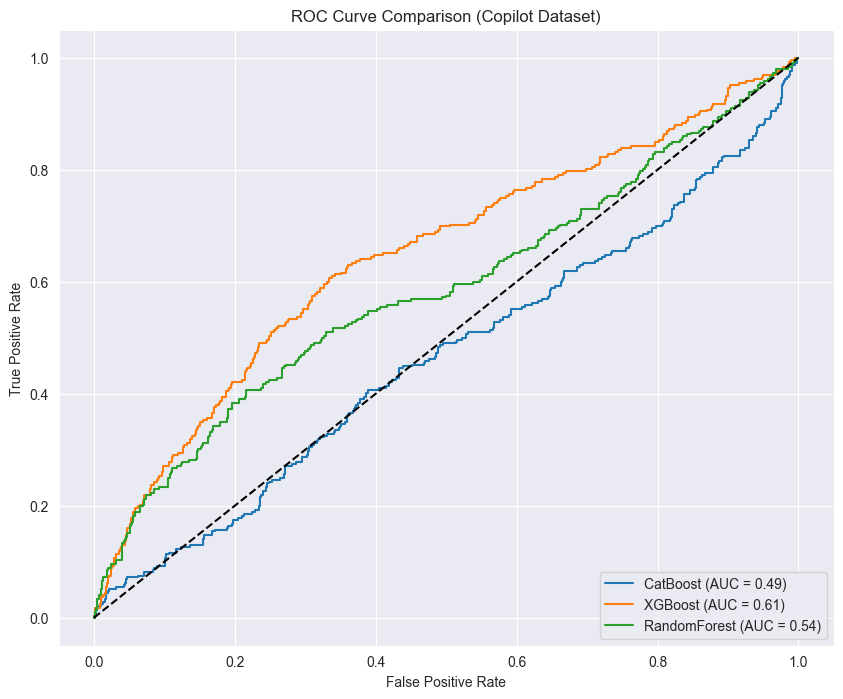

In [31]:
# Plot ROC curves for copilot dataset
plt.figure(figsize=(10, 8))
for model_name, result in results_copilot.items():
    fpr, tpr, _ = roc_curve(y_test_full, result['y_pred_proba'][:, 1], pos_label=1)
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {result["roc_auc"]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison (Copilot Dataset)')
plt.legend(loc='lower right')
plt.show()

In [32]:
# Print results for deepseek dataset
print("\nResults for Deepseek Dataset:")
for model_name, result in results_deepseek.items():
    print(f"\nModel: {model_name}")
    print(f"Accuracy: {result['accuracy']:.4f}")
    print(f"Precision: {result['precision']:.4f}")
    print(f"Recall: {result['recall']:.4f}")
    print(f"F1-Score: {result['f1']:.4f}")
    print(f"ROC-AUC: {result['roc_auc']:.4f}")


Results for Deepseek Dataset:

Model: CatBoost
Accuracy: 0.8384
Precision: 0.8453
Recall: 0.8384
F1-Score: 0.8266
ROC-AUC: 0.9352

Model: XGBoost
Accuracy: 0.8282
Precision: 0.8259
Recall: 0.8282
F1-Score: 0.8269
ROC-AUC: 0.9115

Model: RandomForest
Accuracy: 0.8633
Precision: 0.8624
Recall: 0.8633
F1-Score: 0.8565
ROC-AUC: 0.9480


In [33]:
# Print results for copilot dataset
print("\nResults for Copilot Dataset:")
for model_name, result in results_copilot.items():
    print(f"\nModel: {model_name}")
    print(f"Accuracy: {result['accuracy']:.4f}")
    print(f"Precision: {result['precision']:.4f}")
    print(f"Recall: {result['recall']:.4f}")
    print(f"F1-Score: {result['f1']:.4f}")
    print(f"ROC-AUC: {result['roc_auc']:.4f}")


Results for Copilot Dataset:

Model: CatBoost
Accuracy: 0.3028
Precision: 0.3465
Recall: 0.3028
F1-Score: 0.3011
ROC-AUC: 0.4925

Model: XGBoost
Accuracy: 0.5243
Precision: 0.5258
Recall: 0.5243
F1-Score: 0.5231
ROC-AUC: 0.6057

Model: RandomForest
Accuracy: 0.3785
Precision: 0.4217
Recall: 0.3785
F1-Score: 0.3821
ROC-AUC: 0.5406


Фінальне порівняння моделей на всіх датасетах:
     Dataset         Model  Accuracy  Precision    Recall  F1-Score   ROC-AUC
0   Original      CatBoost  0.750282   0.725884  0.750282  0.727973  0.855736
1   Original       XGBoost  0.749153   0.742569  0.749153  0.741643  0.861028
2   Original  RandomForest  0.758192   0.739895  0.758192  0.739488  0.869017
3     Sliced      CatBoost  0.771751   0.803621  0.771751  0.733345  0.891036
4     Sliced       XGBoost  0.814689   0.809171  0.814689  0.810969  0.900716
5     Sliced  RandomForest  0.840678   0.842322  0.840678  0.830701  0.920052
6        GPT      CatBoost  0.750282   0.725884  0.750282  0.727973  0.855736
7        GPT       XGBoost  0.749153   0.742569  0.749153  0.741643  0.861028
8        GPT  RandomForest  0.758192   0.739895  0.758192  0.739488  0.869017
9   Deepseek      CatBoost  0.838418   0.845263  0.838418  0.826602  0.935229
10  Deepseek       XGBoost  0.828249   0.825910  0.828249  0.826862  0.911523
11  Deepseek  Ran

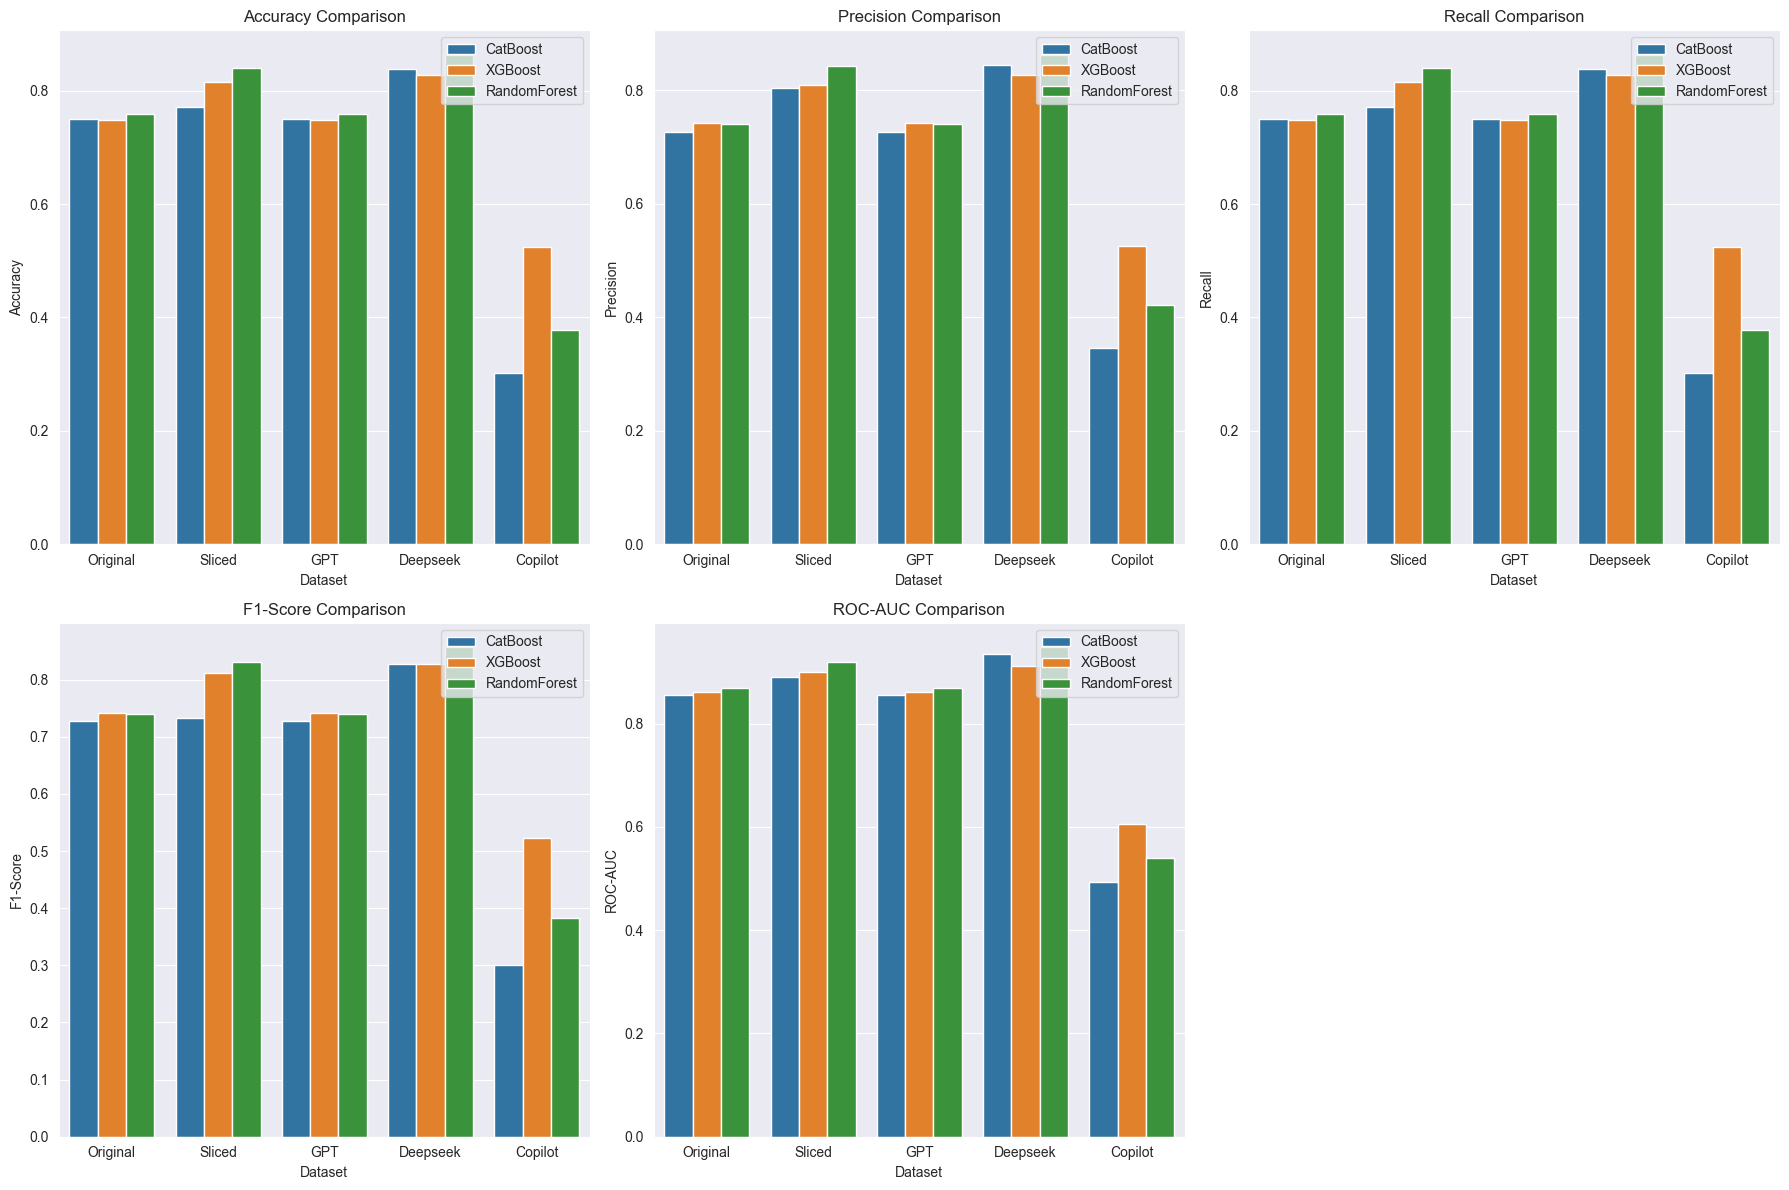

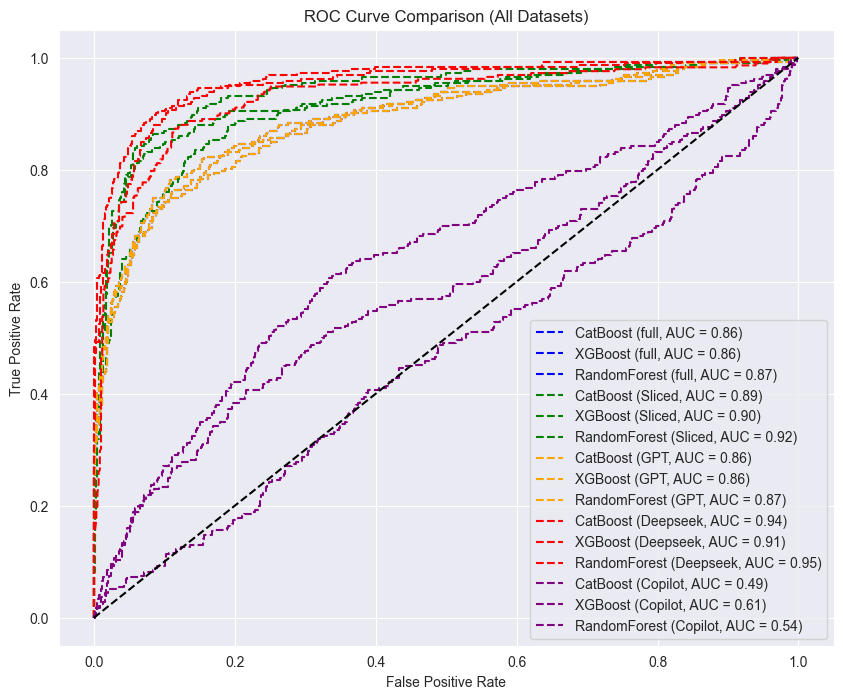

In [37]:
results = {
    'Dataset': [],
    'Model': [],
    'Accuracy': [],
    'Precision': [],
    'Recall': [],
    'F1-Score': [],
    'ROC-AUC': []
}

# Додаємо результати для оригінального датасету
for model_name, result in results_full.items():
    results['Dataset'].append('Original')
    results['Model'].append(model_name)
    results['Accuracy'].append(result['accuracy'])
    results['Precision'].append(result['precision'])
    results['Recall'].append(result['recall'])
    results['F1-Score'].append(result['f1'])
    results['ROC-AUC'].append(result['roc_auc'])

for model_name, result in results_sliced.items():
    results['Dataset'].append('Sliced')
    results['Model'].append(model_name)
    results['Accuracy'].append(result['accuracy'])
    results['Precision'].append(result['precision'])
    results['Recall'].append(result['recall'])
    results['F1-Score'].append(result['f1'])
    results['ROC-AUC'].append(result['roc_auc'])

for model_name, result in results_gpt.items():
    results['Dataset'].append('GPT')
    results['Model'].append(model_name)
    results['Accuracy'].append(result['accuracy'])
    results['Precision'].append(result['precision'])
    results['Recall'].append(result['recall'])
    results['F1-Score'].append(result['f1'])
    results['ROC-AUC'].append(result['roc_auc'])

# Додаємо результати для deepseek датасету
for model_name, result in results_deepseek.items():
    results['Dataset'].append('Deepseek')
    results['Model'].append(model_name)
    results['Accuracy'].append(result['accuracy'])
    results['Precision'].append(result['precision'])
    results['Recall'].append(result['recall'])
    results['F1-Score'].append(result['f1'])
    results['ROC-AUC'].append(result['roc_auc'])

# Додаємо результати для copilot датасету
for model_name, result in results_copilot.items():
    results['Dataset'].append('Copilot')
    results['Model'].append(model_name)
    results['Accuracy'].append(result['accuracy'])
    results['Precision'].append(result['precision'])
    results['Recall'].append(result['recall'])
    results['F1-Score'].append(result['f1'])
    results['ROC-AUC'].append(result['roc_auc'])

# Створюємо DataFrame з результатами
results_df = pd.DataFrame(results)

# Виводимо таблицю з метриками
print("Фінальне порівняння моделей на всіх датасетах:")
print(results_df)

# Графіки для кожної метрики
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']
plt.figure(figsize=(18, 12))
for i, metric in enumerate(metrics, 1):
    plt.subplot(2, 3, i)
    sns.barplot(data=results_df, x='Dataset', y=metric, hue='Model')
    plt.title(f'{metric} Comparison')
    plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

# Загальний графік ROC-кривих для всіх моделей і датасетів
plt.figure(figsize=(10, 8))
for dataset, color in zip(['full', 'Sliced','GPT','Deepseek', 'Copilot'], ['blue', 'green', 'orange','red', 'purple','yellow']):
    for model_name, result in eval(f'results_{dataset.lower()}').items():
        fpr, tpr, _ = roc_curve(y_test_full, result['y_pred_proba'][:, 1], pos_label=1)
        plt.plot(fpr, tpr, label=f'{model_name} ({dataset}, AUC = {result["roc_auc"]:.2f})', color=color, linestyle='--' if dataset != 'Original' else '-')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison (All Datasets)')
plt.legend(loc='lower right')
plt.show()